In [1]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
import yaml
from datetime import timedelta
from nltk.corpus import stopwords 
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import plotly.io as pio
pio.renderers.default='iframe'
import re
from util import *
from hdbscan import HDBSCAN
from ctransformers import AutoModelForCausalLM
from transformers import AutoTokenizer, pipeline
from bertopic.representation import TextGeneration
import random

##  Caricamento del dataset
Carichiamo `deghi_dataset.csv` (separator `§`). Campi principali: `IdReview`, `Stars`, `Title`, `Text`, `CreatedAt`, ecc.

In [2]:
# carica il CSV
df_deghi = pd.read_csv("deghi_dataset.csv", sep="§")

C:\Users\cognos\AppData\Local\Temp\ipykernel_21948\1260288471.py:2: ParserWarning:

Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.



In [3]:
df_deghi.head(10)

,IdReview,Stars,Title,Text,CreatedAt,ExperiencedAt,BusinessUnitId,IdentifyingName,DisplayName
0,54f86d620000ff0002d22209,1,MANCATA APPLICAZIONE GARANZIA LEGALE 2 ANNI.,"Deghishop poco seria, non espleta quanto previ...",2015-03-05 15:51:14.000,NaN,60e079bc8e301d0001f1a420,deghi.it,DEGHI
1,55378fcd0000ff0002df5450,1,PESSIMI!!!!,Servizio assistenza SCANDALOSO!!!\r\nCompro ma...,2015-04-22 14:10:53.000,NaN,60e079bc8e301d0001f1a420,deghi.it,DEGHI
2,565ed9a90000ff00091fcaff,3,Inizialmente poca serietà poi...si sono fatti ...,E' la prima volta che mi trovo a dover descriv...,2015-12-02 12:44:41.000,NaN,60e079bc8e301d0001f1a420,deghi.it,DEGHI
3,567fc4c30000ff000929533d,1,MAI PIU' UN ACQUISTO SU DEGHI SHOP,Ho acquistato un mobile per il bagno il 23 no...,2015-12-27 12:00:19.860,NaN,60e079bc8e301d0001f1a420,deghi.it,DEGHI
4,56d3536e0000ff0009404649,2,merce recapitata con notevole ritardo,ho acquistato su Deghishop.it i sanitari sospe...,2016-02-28 21:07:10.000,NaN,60e079bc8e301d0001f1a420,deghi.it,DEGHI
5,56f6dcc80000ff000949c7c1,2,20 GIORNI PER AVERE IL BOX DOCCIA REGOLABILE G...,DOPO 20 GIORNI DI ATTESA IL BOX DOCCIA ORDINAT...,2016-03-26 20:02:32.000,NaN,60e079bc8e301d0001f1a420,deghi.it,DEGHI
6,5721cb110000ff00095559f2,3,Se c'è un problema il sistema si inceppa,Update: richiamato dal customer service per av...,2016-04-28 10:34:25.000,NaN,60e079bc8e301d0001f1a420,deghi.it,DEGHI
7,57685e0a0000ff00096840a6,1,merce difettosa,PESSIMA ASSITENZA!!! ho acquistato un set da g...,2016-06-20 23:20:10.000,NaN,60e079bc8e301d0001f1a420,deghi.it,DEGHI
8,578ff58e0000ff000972b26d,3,"il servizio prevendita ha sbagliato, e io ci h...","Per necessità di montaggio, prima di comprare...",2016-07-21 00:05:02.000,NaN,60e079bc8e301d0001f1a420,deghi.it,DEGHI
9,5845886cd099d902b4f4c7cd,1,Pessimi. Mai più,Ho ordinato un lavabo d'appoggio il 4 novembre...,2016-12-05 16:31:56.077,NaN,60e079bc8e301d0001f1a420,deghi.it,DEGHI


## Pulizia del testo (`puliscidataset`)
Minuscole, rimozione di punteggiatura/simboli/numeri e sostituzione di `€` con `euro`. Serve a ridurre il rumore per embeddings e clustering.


In [4]:
def puliscidataset(df):

        df['Text']=df['Text'].str.lower() #minuscolo

        symbols = "£x!\"#$%&()*+-/<=>?@[\]^_`{|}~\n"           #punteggiatura 

        for i in symbols:
                         df['Text'] = df['Text'].str.replace(i,' ',regex=False)

        df['Text'] = df['Text'].str.replace("'",' ',regex=False)
        df['Text'] = df['Text'].str.replace('€', 'euro ',regex=True)

        df=df[df['Text'].notna()]

        df['Text'] = df['Text'].str.replace('\d+', '',regex=False)
            
        #rimuovi numeri    
        df["Text"]=df["Text"].apply(lambda x: ' '.join([i for i in x.split() if not i.isdigit()]))    
    
        # Rimuovi parole che contengono numeri 
        #df['Nota'] = df['Nota'].apply(lambda x: ' '.join([i for i in x.split() if not re.search(r'\d', i)]))
       
        return df

In [5]:
df_deghi=puliscidataset(df_deghi).copy()

## Statistiche descrittive e distribuzioni
Calcoliamo n° parole/caratteri e visualizzo istogrammi per valutare lunghezza e variabilità dei testi.

In [6]:
# Conta parole e caratteri
df_deghi["n_parole"] = df_deghi["Text"].astype(str).apply(lambda x: len(x.split()))
df_deghi["n_caratteri"] = df_deghi["Text"].astype(str).apply(len)

In [7]:
# Statistiche descrittive
print(df_deghi[["n_parole", "n_caratteri"]].describe())

# Distribuzione lunghezze
print(df_deghi["n_parole"].value_counts().sort_index().head(20))  # primi 20 valori

          n_parole  n_caratteri
count  1416.000000  1416.000000
mean     89.947034   548.425847
std      82.719258   502.266552
min       2.000000    13.000000
25%      35.000000   223.000000
50%      67.000000   407.500000
75%     112.000000   680.000000
max     657.000000  3917.000000
n_parole
2      6
3      6
4      7
5      5
6     10
7     13
8      7
9      7
10    10
11     4
12     7
13     3
14     9
15    13
16    13
17    12
18    11
19    14
20    12
21    12
Name: count, dtype: int64


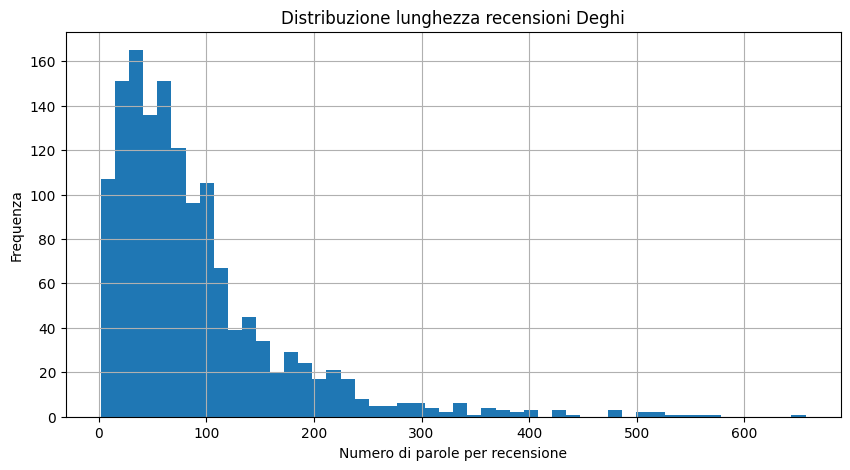

In [8]:
import matplotlib.pyplot as plt

df_deghi["n_parole"].hist(bins=50, figsize=(10,5))
plt.xlabel("Numero di parole per recensione")
plt.ylabel("Frequenza")
plt.title("Distribuzione lunghezza recensioni Deghi")
plt.show()

# Sentence splitting
Questo blocco serve a spezzare le recensioni lunghe in “chunk” di frasi e a costruire un nuovo DataFrame con un testo per riga (i chunk), mantenendo l’ID della recensione originale.
### Come funziona
- Usa **spaCy** (`it_core_news_sm`) per fare **sentence splitting** (divisione in frasi).
- `chunk_text_by_sentences(text, max_words, min_words)`:
  - accumula frasi finché aggiungerne un’altra supererebbe `max_words`;
  - chiude il chunk **solo se** ha almeno `min_words` parole, altrimenti continua ad aggregare;
  - aggiunge comunque l’ultimo chunk residuo.
### Perché è utile
- Evita che poche recensioni molto lunghe **dommino** gli embedding e il clustering.
- Crea testi più **omogenei** e **confrontabili** per il topic modeling (es. BERTopic).
- Aumenta il numero di righe (più chunk), ma rende i documenti più corti e informativi.

In [9]:
import pandas as pd
import spacy

# carica modello italiano per split in frasi
nlp = spacy.load("it_core_news_sm")


def chunk_text_by_sentences(text, max_words=40, min_words=20):
    """
    Divide il testo in blocchi di frasi.
    - max_words = lunghezza massima di un blocco
    - min_words = lunghezza minima (se una frase è troppo corta, la unisce a quella successiva)
    """
    doc = nlp(str(text))
    chunks, current_chunk, current_len = [], [], 0

    for sent in doc.sents:
        words = sent.text.split()
        if current_len + len(words) > max_words and current_len >= min_words:
            chunks.append(" ".join(current_chunk))
            current_chunk, current_len = [], 0
        current_chunk.extend(words)
        current_len += len(words)

    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return chunks

# funzione principale
def make_chunked_dataframe(df, text_col="Text", id_col="IdReview", max_words=120, min_words=200):
    """
    Ritorna un nuovo dataframe con le recensioni spezzate in chunk.
    - Se una recensione ha <= min_words parole, resta intera.
    - Se ha > min_words parole, viene divisa in blocchi di max_words.
    """
    docs_chunked = []
    ids = []

    for idx, row in df.iterrows():
        text = str(row[text_col])
        n_words = len(text.split())
        if n_words > min_words:
            for chunk in chunk_text_by_sentences(text, max_words=max_words):
                docs_chunked.append(chunk)
                ids.append(row[id_col])
        else:
            docs_chunked.append(text)
            ids.append(row[id_col])

    return pd.DataFrame({id_col: ids, "Chunk": docs_chunked})

# esempio di utilizzo
df_chunked = make_chunked_dataframe(df_deghi, text_col="Text", id_col="IdReview",
                                    max_words=20, min_words=10)

print(df_chunked.head())
print("Dimensioni dataframe originale:", df_deghi.shape)
print("Dimensioni dataframe chunked:", df_chunked.shape)

                   IdReview                                              Chunk
0  54f86d620000ff0002d22209  deghishop poco seria, non espleta quanto previ...
1  54f86d620000ff0002d22209  di fatto, pur avendo ricevuto la seguente e ma...
2  54f86d620000ff0002d22209  servizio clienti deghi da: ............ .........
3  54f86d620000ff0002d22209  possesso. ............................. i temp...
4  55378fcd0000ff0002df5450  servizio assistenza scandaloso compro material...
Dimensioni dataframe originale: (1416, 11)
Dimensioni dataframe chunked: (4187, 2)


In [10]:
# Conta parole e caratteri
df_chunked["n_parole"] = df_chunked["Chunk"].astype(str).apply(lambda x: len(x.split()))
df_chunked["n_caratteri"] = df_chunked["Chunk"].astype(str).apply(len)

# Risultato Sentence splitting

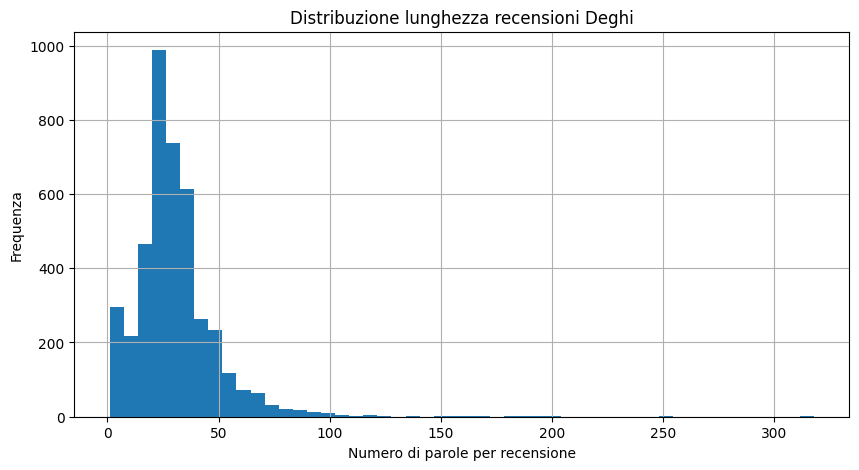

In [11]:
# Se vuoi un istogramma (facoltativo)
import matplotlib.pyplot as plt

df_chunked["n_parole"].hist(bins=50, figsize=(10,5))
plt.xlabel("Numero di parole per recensione")
plt.ylabel("Frequenza")
plt.title("Distribuzione lunghezza recensioni Deghi")
plt.show()

In [12]:
# Statistiche descrittive
print(df_chunked[["n_parole", "n_caratteri"]].describe())

          n_parole  n_caratteri
count  4187.000000  4187.000000
mean     30.471698   184.862670
std      18.709905   111.652762
min       1.000000     2.000000
25%      21.000000   126.000000
50%      27.000000   167.000000
75%      37.000000   226.000000
max     318.000000  1910.000000


In [13]:
# prendi la colonna 'Text' come lista
docs = df_chunked["Chunk"].dropna().tolist()

In [14]:
#docs

# Traduce le singole note in vettori embeddings
Creiamo embeddings con `paraphrase-multilingual-MiniLM-L12-v2` per rappresentare semanticamente i testi.


In [15]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
#embeddings = embedding_model.encode(df_chunked["Chunk"].tolist(), show_progress_bar=True)
# modello monolingua italiano
#embedding_model = SentenceTransformer("nickprock/sentence-bert-base-italian-uncased")

## Etichettatura topic con LLM

In [16]:
from bertopic.representation import KeyBERTInspired
prompt = """<|system|>Sei un assistete che analizza documenti da un crm di una azienda di mobili per fornire ad un dirigente aspetti critici e negativi che appaiono nei documenti</s>
<|user|>
I seguenti documenti sono presi da un CRM di assistenza clienti di una azienda che vende mobili d'arredamento:
[DOCUMENTS]

Il tema è descritto dalle seguenti parole chiave:  '[KEYWORDS]'.

Sulla base delle informazioni sopra, puoi fornire una breve etichetta del topic di massimo 5 parole?</s>
<|assistant|>"""


from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import pipeline



model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-Nemo-Instruct-2407",
    load_in_8bit=True,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-Nemo-Instruct-2407")

generator = pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    max_new_tokens=350,
    repetition_penalty=1.1
)

# Text generation with Zephyr
minstral = TextGeneration(generator, prompt=prompt)
representation_model = {"KeyBERT": KeyBERTInspired(),
                        "LLM": minstral}


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Device set to use cuda:0


In [17]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression

## Riduzione dimensionale (UMAP)
Configuriamo UMAP (n_neighbors, n_components, min_dist, metric) per proiettare embeddings in spazio ridotto.

In [18]:
umap_model = UMAP(
    n_neighbors=30,
    n_components=5,
    min_dist=0.2,
    metric="cosine",
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=15,
    min_samples=10,
    gen_min_span_tree=True, 
    prediction_data=False,
    cluster_selection_method="eom"
)
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# stopword italiane e inglesi
stop_it = stopwords.words("italian")
stop_en = stopwords.words("english")

# unisci le due liste
stop_words = list(set(stop_it + stop_en))

# Fine-tune topic representations after training BERTopic
vectorizer_model = CountVectorizer(stop_words=stop_words, ngram_range=(1, 2), min_df=5)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

In [19]:
topic_model = BERTopic(umap_model=umap_model,hdbscan_model=hdbscan_model,embedding_model=embedding_model,representation_model=representation_model,ctfidf_model=ctfidf_model,  vectorizer_model=vectorizer_model,verbose=True)

## Training del modello

In [20]:
topics, probs = topic_model.fit_transform(docs)

2025-09-09 12:57:11,174 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/131 [00:00<?, ?it/s]

2025-09-09 12:57:13,773 - BERTopic - Embedding - Completed ✓
2025-09-09 12:57:13,774 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-09 12:57:45,631 - BERTopic - Dimensionality - Completed ✓
2025-09-09 12:57:45,634 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-09 12:57:45,728 - BERTopic - Cluster - Completed ✓
2025-09-09 12:57:45,732 - BERTopic - Representation - Fine-tuning topics using representation models.
 42%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 10/24 [00:37<00:47,  3.42s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████

# Export risultati

In [21]:
topic_model.get_topic_info().to_csv('../result/topic_info.csv')

In [22]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,2065,-1_merce_azienda_prodotto_cliente,"[merce, azienda, prodotto, cliente, deghi, ser...","[post vendita, acquistato, servizio clienti, c...",[Problemi con la spedizione e il servizio clie...,"[ho acquistato da deghi un divano, avevo letto..."
1,0,648,0_lavorativi_giorni lavorativi_mail_giorni,"[lavorativi, giorni lavorativi, mail, giorni, ...","[tempi consegna, giorni lavorativi, dopo giorn...",[Problemi di spedizione e consegna dei prodott...,[dicono giorni lavorativi per la merce...siamo...
2,1,339,1_sedie_tavolo_viti_punti,"[sedie, tavolo, viti, punti, legno, montaggio,...","[tavolo arrivato, ordinato tavolo, tavolo, scr...",[Problemi con mobili difettosi e ritardi nelle...,[ordinato un tavolo che è esattamente come era...
3,2,220,2_doccia_bagno_lavabo_bo doccia,"[doccia, bagno, lavabo, bo doccia, bo, mobile,...","[doccia, bo doccia, bagno, acqua, lavabo, spec...",[Problemi di qualità dei prodotti e servizio p...,[in gennaio ho acquistato un bo doccia in pvc ...
4,3,129,3_grazie_mai piu_mai_piu,"[grazie, mai piu, mai, piu, ok, evitare, compl...","[mai piu, mai, altrimenti, insomma, finito, ba...",[Problemi con i prodotti e il servizio clienti...,"[a mai piu, mai piu deghi, è inutile che rispo..."
5,4,89,4_euro_pagato_valore_circa,"[euro, pagato, valore, circa, piano, costo, pr...","[euro, rimborso parziale, pagato, spesa, costo...","[Problemi con resi e rimborsi, , , , , , , , , ]",[pessimi acquistato termoarredo euro con paypa...
6,5,83,5_mobile_tv_rovinato_mobiletto,"[mobile, tv, rovinato, mobiletto, mobili, prot...","[mobile, mobiletto, mobili, rovinato, imballag...",[Problemi con la qualità dei mobili e il servi...,[ma la delusione maggiore è stato il “servizio...
7,6,75,6_qualità prezzo_rapporto_prezzi_negozio,"[qualità prezzo, rapporto, prezzi, negozio, ra...","[qualità prezzo, buoni prezzi, acquisti deghi,...",[Problemi con le spedizioni e buono rapporto q...,[buoni prodotti che hanno il giusto rapporto q...
8,7,67,7_paypal_soldi_rimborso_pagamento,"[paypal, soldi, rimborso, pagamento, chiesto r...","[chiesto rimborso, restituzione, pagare, pagam...","[Rimborsi e problemi di consegna, , , , , , , ...",[in ogni caso io ho richiesto il rimborso perc...
9,8,62,8_qualità_prodotto_materiali_prezzo,"[qualità, prodotto, materiali, prezzo, prodott...","[qualità prodotti, scarsa qualità, bassa quali...","[Qualità dei prodotti insoddisfacente, , , , ,...",[peccato non poter allegare le foto alle recen...


# Visualizzazioni
Gerarchia topic (BERTopic) e mappa 2D (datamapplot) per esplorare separazione e macro-temi.

In [23]:
fig = topic_model.visualize_hierarchy()
fig.show()

## Dendogramma

In [24]:
import datamapplot
import re

In [25]:
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/131 [00:00<?, ?it/s]

In [26]:
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

## Mappa dei Cluster

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'left': 'Topics generati con  mistralai/Mistral-Nemo-Instruct-2407'}>)

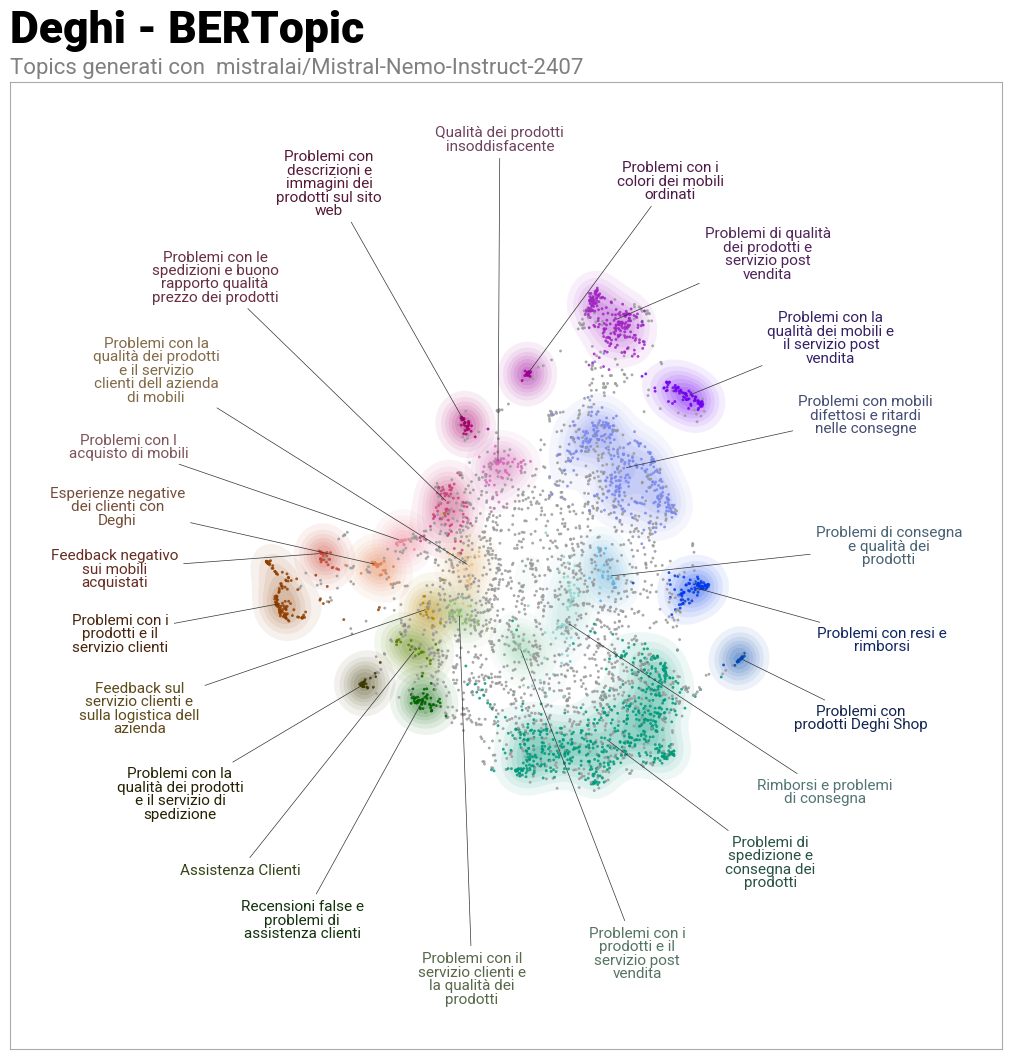

In [27]:
# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="Deghi - BERTopic",
    sub_title="Topics generati con  mistralai/Mistral-Nemo-Instruct-2407",
    label_wrap_width=20,
    use_medoids=True,
    #logo=bertopic_logo,
    #logo_width=0.16
)